In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import requests
import io
from collections import Counter
import re
from datetime import datetime

import nltk
import spacy
from wordcloud import WordCloud

pd.set_option("display.max_colwidth", 200)
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

nlp = spacy.load("en_core_web_sm")

In [2]:
# CFPB CSV export URL (Mortgage 2024 with narratives)
URL = (
    "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/"
    "?date_received_min=2024-01-01"
    "&date_received_max=2024-12-31"
    "&product=Mortgage"
    "&has_narrative=true"
    "&format=csv"
    "&no_aggs=true"
    "&field=all"
    "&size=12208"
)

r = requests.get(URL, timeout=120)
r.raise_for_status()

df = pd.read_csv(io.BytesIO(r.content))
print(f"Loaded dataset: {df.shape[0]:,} records, {df.shape[1]} columns")

# Clean + standardize (use correct column names from export)
rename_map = {
    "Date received": "date_received",
    "Product": "product",
    "Issue": "issue",
    "Company": "company",
    "Consumer complaint narrative": "complaint_what_happened"
}

df = df.rename(columns=rename_map)

# Drop missing or empty complaint narratives
df = df.dropna(subset=["complaint_what_happened"])
df["complaint_what_happened"] = df["complaint_what_happened"].astype(str).str.strip()
df = df[df["complaint_what_happened"] != ""]

print("\n Preview:")
print(df[["date_received", "product", "issue", "company", "complaint_what_happened"]].head(3))
print(f"\n After filtering empty narratives: {df.shape[0]:,} records remain")

# Save cleaned data
output_path = "../data/raw/cfpb_mortgage_2024.csv"
df.to_csv(output_path, index=False)
print(f"Saved cleaned dataset to {output_path}")

Loaded dataset: 12,208 records, 18 columns

 Preview:
  date_received   product                           issue  \
0      12/30/24  Mortgage      Struggling to pay mortgage   
1      09/24/24  Mortgage      Struggling to pay mortgage   
2      04/19/24  Mortgage  Trouble during payment process   

                                company  \
0  United Shore Financial Services, LLC   
1                    Fay Servicing, LLC   
2                  JPMORGAN CHASE & CO.   

                                                                                                                                                                                   complaint_what_happened  
0  I am filing a complaint against United Wholesale Mortgage Company for Practices of Unfair, Deceptive & abusive Acts committed against me. \nIn the summer of XXXX, I XXXX XXXX XXXX XXXX XXXX XXXX X...  
1  XXXX XXXXXXXX XXXX XXXX XX/XX/XXXX Mortgage XXXX reflected {>= $1,000,000} overdue and the monthly payment was {$13

In [83]:
print(df.columns.tolist())

['date_received', 'product', 'Sub-product', 'issue', 'Sub-issue', 'complaint_what_happened', 'Company public response', 'company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']


Loaded: 12,208 rows, 18 columns

Columns:
 ['date_received', 'product', 'Sub-product', 'issue', 'Sub-issue', 'complaint_what_happened', 'Company public response', 'company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

🔍 Data types:
date_received                 object
product                       object
sub_product                   object
issue                         object
sub_issue                     object
complaint_what_happened       object
company_public_response       object
company                       object
state                         object
zip_code                      object
tags                          object
consumer_consent_provided     object
submitted_via                 object
date_sent_to_company          object
company_response              object
timely                        object
consumer_disputed            

/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_54143/2561906393.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date_received"] = pd.to_datetime(df["date_received"], errors="coerce")



Basic Summary:
- Total complaints: 12,208
- Companies: 538
- Issues: 10
- States: 55
- Date range: 2024-01-01 00:00:00 → 2024-12-31 00:00:00
- Median text length: 198.0 words


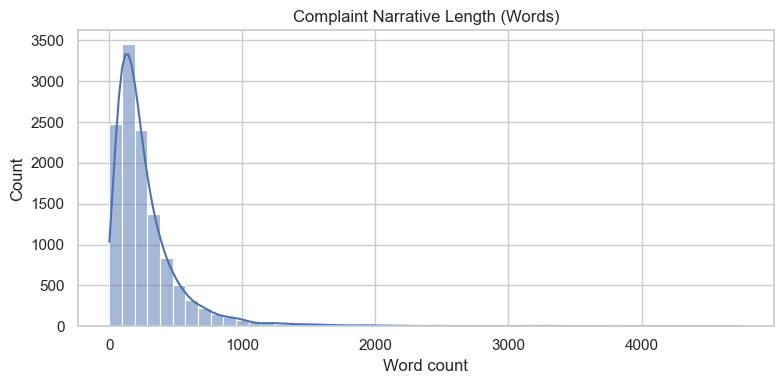

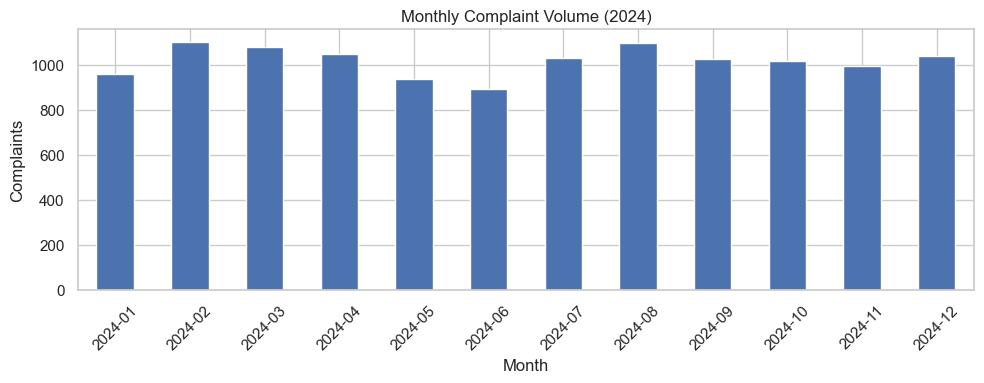

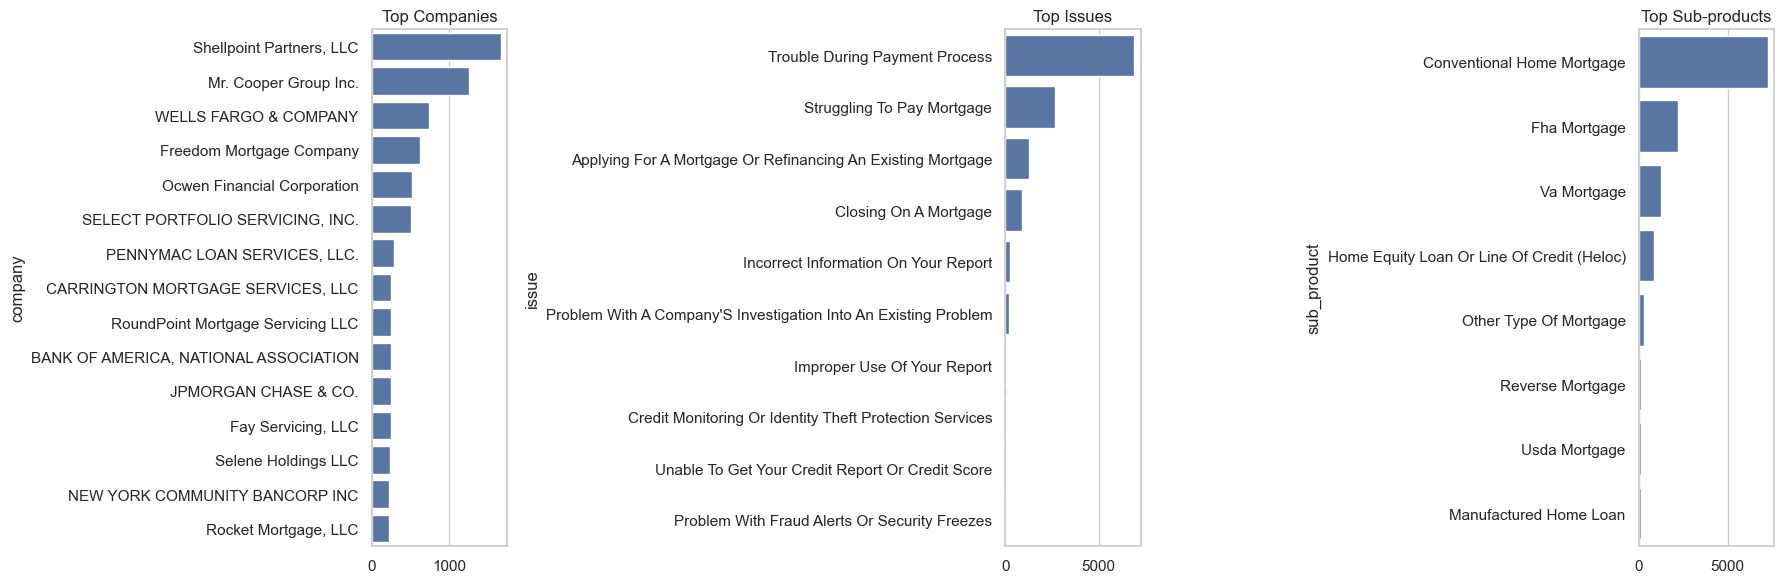

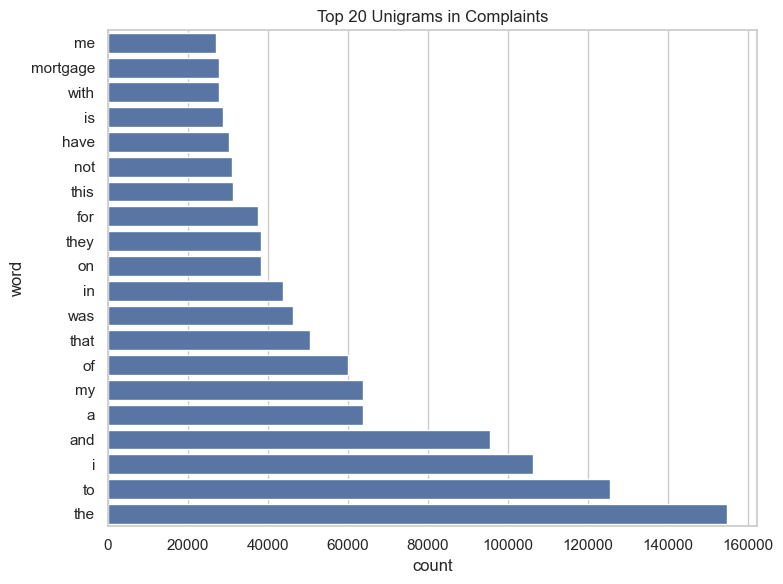

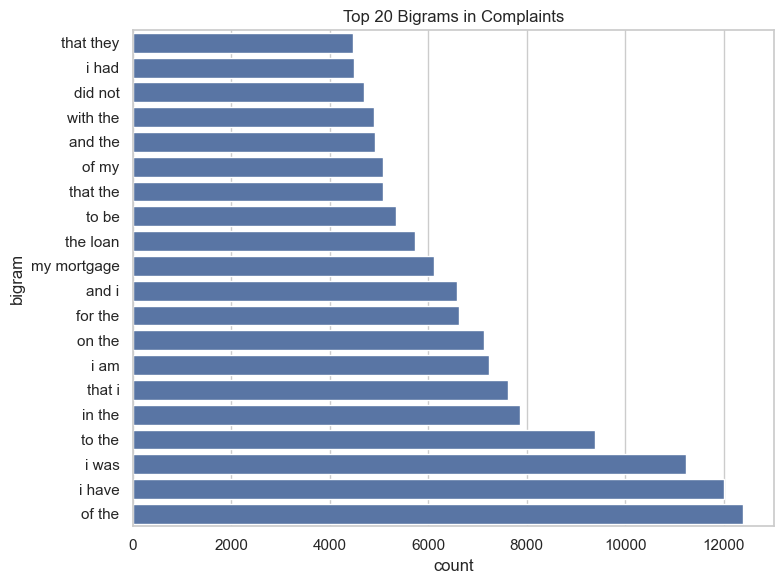

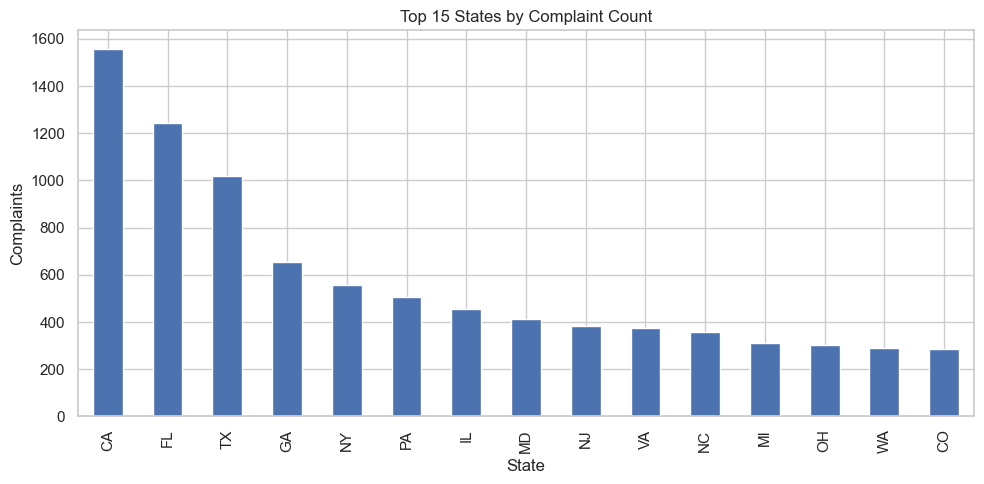

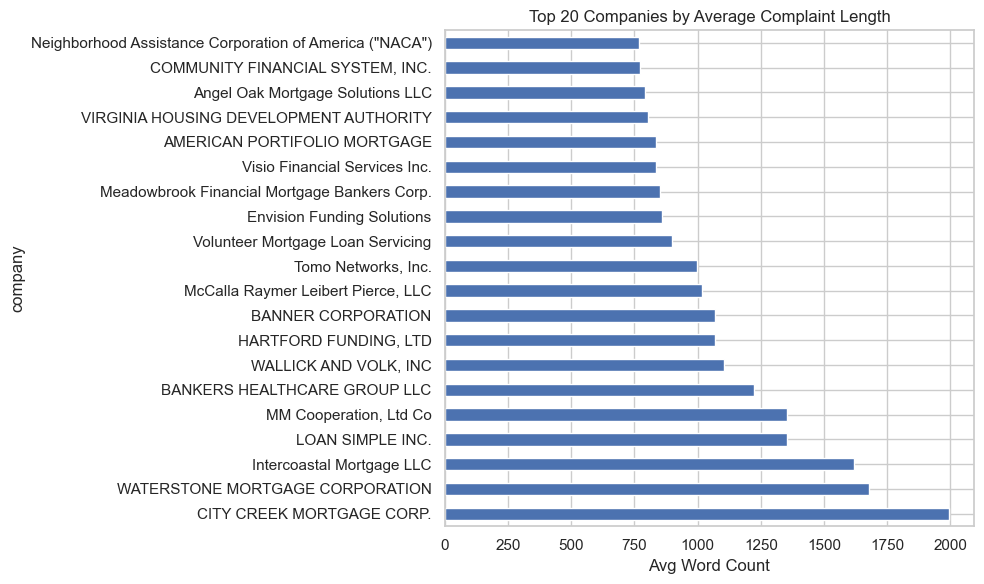

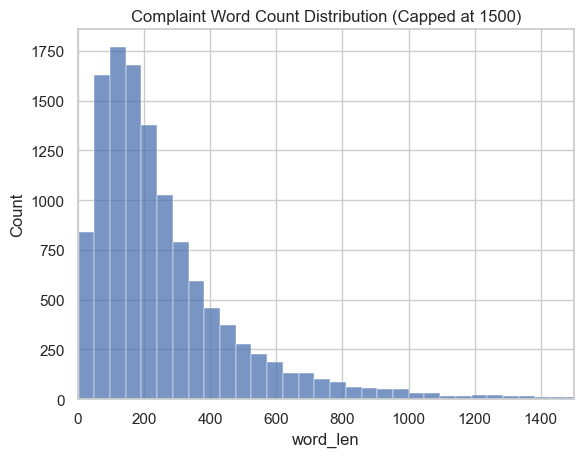

Shellpoint Partners, LLC | Applying For A Mortgage Or Refinancing An Existing Mortgage
i am filing this complaint against newrez and shellpoint regarding a va loan assumption please let it be known that i have been bounced back and forth between two departments within this company five times i believe we are looking at shellpoint and newrez one is an assumption loan which is a cost effective process in which i assume the va loan which currently belongs to my ex husband it should be a simple process fill out the forms and file it which we did the department has no phone number and no secured portal in order to upload private and sensitive information yet they continue to demand i email it through so i had to mail everything via the united postal service which takes time furthermore let it be noted that the two departments do not communicate and i have had to send the same for ...
Shellpoint Partners, LLC | Closing On A Mortgage
i am owed from newrez following the closing payoff of my lo

In [84]:
print(f"Loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print("\nColumns:\n", list(df.columns))

# Rename columns to standard names for consistency
df = df.rename(columns={
    "Date received": "date_received",
    "Product": "product",
    "Sub-product": "sub_product",
    "Issue": "issue",
    "Sub-issue": "sub_issue",
    "Consumer complaint narrative": "complaint_what_happened",
    "Company public response": "company_public_response",
    "Company": "company",
    "State": "state",
    "ZIP code": "zip_code",
    "Tags": "tags",
    "Consumer consent provided?": "consumer_consent_provided",
    "Submitted via": "submitted_via",
    "Date sent to company": "date_sent_to_company",
    "Company response to consumer": "company_response",
    "Timely response?": "timely",
    "Consumer disputed?": "consumer_disputed",
    "Complaint ID": "complaint_id"
})


# Basic info and null values
print("\n🔍 Data types:")
print(df.dtypes)

print("\n🔢 Missing values:")
print(df.isnull().mean().sort_values(ascending=False).head(10))

# Parse dates
df["date_received"] = pd.to_datetime(df["date_received"], errors="coerce")

# Text cleaning 
def clean_cfpb_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"x{2,}", " ", text)               # XXXX redactions
    text = re.sub(r"\d{2,4}", " ", text)             # dates / IDs
    text = re.sub(r"[_\-]{2,}", " ", text)           # --- or ___
    text = re.sub(r"[^a-z\s]", " ", text)            # letters only
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["complaint_what_happened"].apply(clean_cfpb_text)
df["char_len"] = df["complaint_what_happened"].str.len()
df["word_len"] = df["clean_text"].str.split().apply(len)

# trim all whitespaces and normalize strings
text_cols = ["company", "issue", "sub_product", "sub_issue", "state", "tags"]
for c in text_cols:
    df[c] = df[c].astype(str).str.strip().str.normalize('NFKC')

# standardize case for categorical fields
df["issue"] = df["issue"].str.title()
df["sub_product"] = df["sub_product"].str.title()

# Replace placeholder values
df.replace(to_replace=r"(?i)\b(n/?a|none|nan)\b", value=pd.NA, regex=True, inplace=True)

# Standardize ZIP codes
df["zip_code"] = df["zip_code"].astype(str).str[:5].str.zfill(5)

# Complaints over time
df["month"] = df["date_received"].dt.to_period("M").astype(str)
monthly = df["month"].value_counts().sort_index()

# Remove unused columns
final_cols = [
    "complaint_id", "date_received", "company", "issue", "sub_product",
    "clean_text", "word_len", "company_response", "timely", "state", "month"
]
df = df[final_cols]

# Summary statistics
print("\nBasic Summary:")
print(f"- Total complaints: {len(df):,}")
print(f"- Companies: {df['company'].nunique()}")
print(f"- Issues: {df['issue'].nunique()}")
print(f"- States: {df['state'].nunique()}")
print(f"- Date range: {df['date_received'].min()} → {df['date_received'].max()}")
print(f"- Median text length: {df['word_len'].median()} words")

# Descriptive plots
sns.set(style="whitegrid")

# Complaint length distribution
plt.figure(figsize=(8,4))
sns.histplot(df["word_len"], bins=50, kde=True)
plt.title("Complaint Narrative Length (Words)")
plt.xlabel("Word count")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4))
monthly.plot(kind="bar")
plt.title("Monthly Complaint Volume (2024)")
plt.ylabel("Complaints")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top companies, issues, sub-products
top_companies = df["company"].value_counts().head(15)
top_issues = df["issue"].value_counts().head(15)
top_subproducts = df["sub_product"].value_counts().head(15)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(y=top_companies.index, x=top_companies.values, ax=axes[0])
axes[0].set_title("Top Companies")
sns.barplot(y=top_issues.index, x=top_issues.values, ax=axes[1])
axes[1].set_title("Top Issues")
sns.barplot(y=top_subproducts.index, x=top_subproducts.values, ax=axes[2])
axes[2].set_title("Top Sub-products")
plt.tight_layout()
plt.show()

df["clean_text"] = df["clean_text"].fillna("").astype(str)

# Token frequency (unigrams + bigrams)
from collections import Counter

def top_unigrams(texts, n=20):
    counter = Counter()
    for t in texts.dropna():             
        if isinstance(t, str):
            counter.update(t.split())
    return pd.DataFrame(counter.most_common(n), columns=["word", "count"])

def top_bigrams(texts, n=20):
    counter = Counter()
    for t in texts:
        tokens = t.split()
        bigrams = zip(tokens, tokens[1:])
        counter.update([" ".join(bg) for bg in bigrams])
    return pd.DataFrame(counter.most_common(n), columns=["bigram", "count"])

uni = top_unigrams(df["clean_text"])
bi = top_bigrams(df["clean_text"])

plt.figure(figsize=(8,6))
sns.barplot(y=uni["word"].iloc[::-1], x=uni["count"].iloc[::-1])
plt.title("Top 20 Unigrams in Complaints")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(y=bi["bigram"].iloc[::-1], x=bi["count"].iloc[::-1])
plt.title("Top 20 Bigrams in Complaints")
plt.tight_layout()
plt.show()

# state-evel complaint distribution
plt.figure(figsize=(10,5))
df["state"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 States by Complaint Count")
plt.xlabel("State")
plt.ylabel("Complaints")
plt.tight_layout()
plt.show()

#Average narrative length per company
avg_len = (
    df.groupby("company")["word_len"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)
plt.figure(figsize=(10,6))
avg_len.plot(kind="barh")
plt.title("Top 20 Companies by Average Complaint Length")
plt.xlabel("Avg Word Count")
plt.tight_layout()
plt.show()

# Complaint word count distribution
sns.histplot(df['word_len'], bins=100)
plt.xlim(0, 1500)
plt.title("Complaint Word Count Distribution (Capped at 1500)")
plt.show()

#Random sample viewer (qualitative check)
sample_df = df.sample(5, random_state=42)[
    ["company", "issue", "clean_text"]
]
for _, row in sample_df.iterrows():
    print("="*80)
    print(f"{row['company']} | {row['issue']}")
    print(row["clean_text"][:800], "...")



# Save clean dataset
OUTPUT = "../data/interim/cfpb_mortgage_2024_clean.csv"
df.to_csv(OUTPUT, index=False)
print(f"Clean data saved to: {OUTPUT}")